In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
#import helper

%matplotlib inline

In [ ]:
!unzip "/content/drive/My Drive/processed-celeba-small.zip" -d "/content/drive/My Drive/celeba"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171104.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171105.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171106.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171107.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171108.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171109.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171110.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171111.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171112.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/171113.jpg  
  inflating: /content/drive/My Drive/celeba/processed_celeba_small/celeba/17111

In [9]:
def get_dataloader(batch_size, image_size, data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
        
    # Resize the image --> should be image_size x image_size
    
    data_transforms = transforms.Compose([transforms.Resize(image_size), 
                                          transforms.ToTensor()
                                         ])
    
    face_train      = datasets.ImageFolder(root      = data_dir, 
                                           transform = data_transforms
                                          )
    
    train_loader    = torch.utils.data.DataLoader(dataset    = face_train,
                                                  batch_size = batch_size,
                                                  shuffle    = True
                                                 )
    
    return train_loader


In [11]:
# Define function hyperparameters
batch_size = 32
img_size   = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
data_dir = '/content/drive/My Drive/celeba/'
celeba_train_loader = get_dataloader(batch_size, img_size, data_dir)


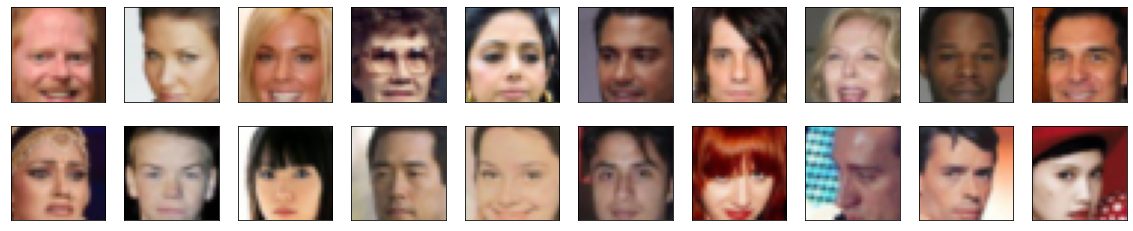

In [12]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [13]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    min, max = feature_range
    x = x * (max - min) + min

    return x


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(1.)


In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """

    layers     = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    seq_layers = nn.Sequential(*layers)
     
    # using Sequential container
    return seq_layers

In [17]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # 3 conv layers
        self.conv1 = conv(3,conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4)
        
        # fc
        self.fc = nn.Linear(conv_dim*4*4*4,1)        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        # HL + activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        
        return x


In [18]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    
    layers = []
    tcl    = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(tcl)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    seq_layers = nn.Sequential(*layers)
    
    return seq_layers

In [19]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # 3 tcl
        self.t_conv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # final fc
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1,self.conv_dim*4, 4, 4)

        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        ##### XXXXX Not a Relu 
        # x = F.relu(self.t_conv3(x))
        x = self.t_conv3(x)
        
        x = F.tanh(x)
        
        return x


In [20]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
    
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)

    return m

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [22]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size     = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [24]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [25]:
import torch.optim as optim

lr = 0.001
beta1= 0.1
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [26]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            
            ####################
            # With real images #
            ####################
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()

            d_real      = D(real_images)
            d_real_loss = real_loss(d_real)
            
            ####################
            # With fake images #
            ####################
            # Generate z vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
        
            # Generate image
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)

            d_fake      = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            ##########
            # D loss #
            ##########
            
            d_loss = d_real_loss + d_fake_loss
            
            ########################
            # Backward + Optomizer #
            ########################
            
            d_loss.backward()
            d_optimizer.step()
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            #######################
            # Generate fake image #
            #######################
            
            # Generate z vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
                    
            #############
            # real_loss #
            #############
            g_fake = D(fake_images)
            g_loss = real_loss(g_fake)
            
            ########################
            # Backward + Optomizer #
            ########################
            
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [27]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.6702 | g_loss: 6.1228
Epoch [    1/   50] | d_loss: 1.4949 | g_loss: 6.2512
Epoch [    1/   50] | d_loss: 1.3225 | g_loss: 1.8104
Epoch [    1/   50] | d_loss: 1.1648 | g_loss: 1.0205
Epoch [    1/   50] | d_loss: 1.3442 | g_loss: 0.7473
Epoch [    1/   50] | d_loss: 1.7029 | g_loss: 0.5519
Epoch [    1/   50] | d_loss: 1.4189 | g_loss: 1.0909
Epoch [    1/   50] | d_loss: 1.7912 | g_loss: 0.5470
Epoch [    1/   50] | d_loss: 1.4679 | g_loss: 1.1745
Epoch [    1/   50] | d_loss: 1.4602 | g_loss: 1.4174
Epoch [    1/   50] | d_loss: 1.2244 | g_loss: 0.8585
Epoch [    1/   50] | d_loss: 1.3975 | g_loss: 0.9338
Epoch [    1/   50] | d_loss: 1.4390 | g_loss: 0.8419
Epoch [    1/   50] | d_loss: 1.2012 | g_loss: 0.8557
Epoch [    1/   50] | d_loss: 1.2061 | g_loss: 0.5249
Epoch [    1/   50] | d_loss: 1.5583 | g_loss: 0.6274
Epoch [    1/   50] | d_loss: 1.5740 | g_loss: 1.0180
Epoch [    1/   50] | d_loss: 1.4658 | g_loss: 0.6890
Epoch [    1/   50] | d_loss

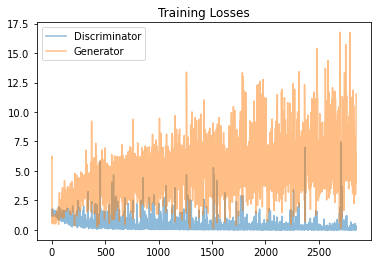

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [30]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

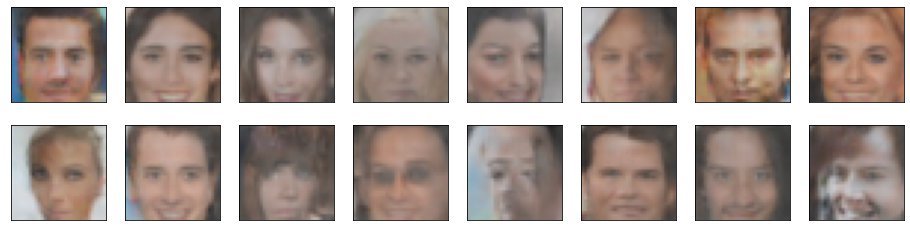

In [31]:
_ = view_samples(-1, samples)